<a href="https://colab.research.google.com/github/Henil21/Diffusion-models-hf/blob/main/Diffusin_HF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ▶    Stable Diffusion Pipeline

**Diffusers** is designed to be a user-friendly and flexible toolbox for building diffusion systems tailored to your use-case. At the core of the toolbox are models and schedulers. `While the DiffusionPipeline bundles these components together for convenience, you can also unbundle the pipeline and use the models and schedulers separately to create new diffusion systems.`




Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cat-256/snapshots/82ca0d5db4a5ec6ff0e9be8d86852490bc18a3d9.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/100 [00:00<?, ?it/s]

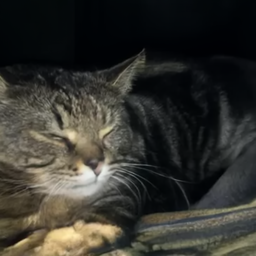

In [6]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")
image = ddpm(num_inference_steps=100).images[0]
image

---


> Denoising is the process of removing unwanted noise from an image

The pipeline denoises an image by taking random noise the size of the desired output and passing it through the model several times. At each timestep, the model predicts the noise residual and the scheduler uses it to predict a less noisy image. The pipeline repeats this process until it reaches the end of the specified number of inference steps.

To recreate the pipeline with the model and scheduler separately, let’s write our own denoising process.

In [7]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256", use_safetensors=True).to("cuda")

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

In [59]:
scheduler.set_timesteps(50)

---

Setting the scheduler timesteps creates a tensor with evenly spaced elements in it, 50 in this example. Each element corresponds to a timestep at which the model denoises an image. When you create the denoising loop later, you’ll iterate over this tensor to denoise an image:

In [60]:
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [61]:
# Create some random noise with the same shape as the desired output:
import torch

sample_size = model.config.sample_size
print(sample_size)
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")

256


---
Now write a loop to iterate over the timesteps. At each timestep, the model does a `UNet2DModel.forward()` pass and returns the noisy residual. The scheduler’s `step()` method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep. This output becomes the next input to the model in the denoising loop, and it’ll repeat until it reaches the end of the timesteps array.

In [62]:
input = noise

for t in scheduler.timesteps: # t is the current timestamp in noise reduction process
    with torch.no_grad(): # using no_grad to disables gradient calculations to save memory and improve performance during inference

        # noisy_residual is the predicted noise that needs to be removed
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

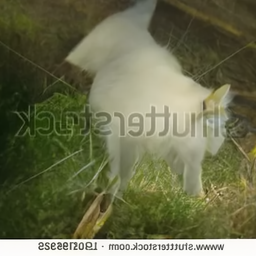

In [63]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

---


## ▶ 🔨 Deconstruct the Stable Diffusion pipeline

---
Stable Diffusion is a text-to-image latent diffusion model. It is called a latent diffusion model because it works with a lower-dimensional representation of the image instead of the actual pixel space, which makes it more memory efficient. The encoder compresses the image into a smaller representation, and a decoder to convert the compressed representation back into an image. For text-to-image models, you’ll need a tokenizer and an encoder to generate text embeddings. From the previous example, you already know you need a UNet model and a scheduler.